In [1]:
%load_ext autoreload
%autoreload 2

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import pygsp
import scipy 

from helper.helper_plot import *

## 3. Graph Signals

### 3.1. Graph Signal Definition

$$
\mathcal{G} = \{ \mathcal{V}, \mathcal{E}, W \}
$$
with 
$$
f : \mathcal{V} \rightarrow \mathbb{R}
$$
Then,
$$
\textbf{f} \in \mathbb{R}^N
$$
with $|\mathcal{V}| = N$, i.e. number of vertices in the graph $\mathcal{G}$.

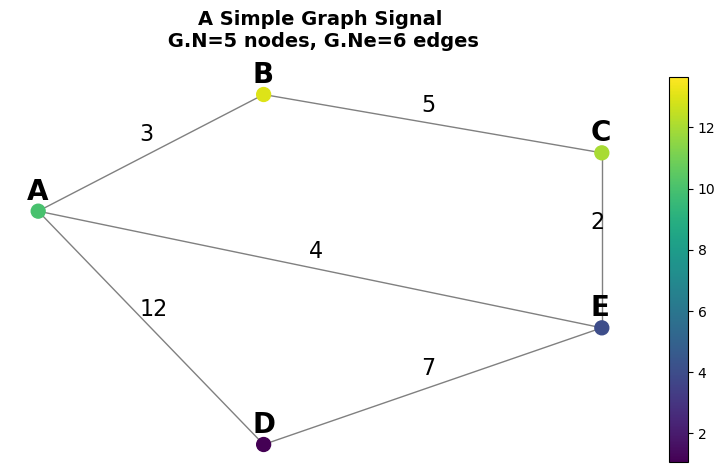

In [5]:
W = np.array([
    [0,3,0,12,4],
    [3,0,5,0,0],
    [0,5,0,0,2],
    [12,0,0,0,7],
    [4,0,2,7,0]
])
G = pygsp.graphs.Graph(W)
myGraphPlotSignal(G, 
            s = np.array([10,13,12,1,4]),
            coords = [[0,5], [2,7], [5,6], [2,1], [5,3]],
            vertex_names=["A", "B", "C", "D", "E"],
            title = "A Simple Graph Signal",
            display_vertexnames = True,
            display_edgeweights = True)

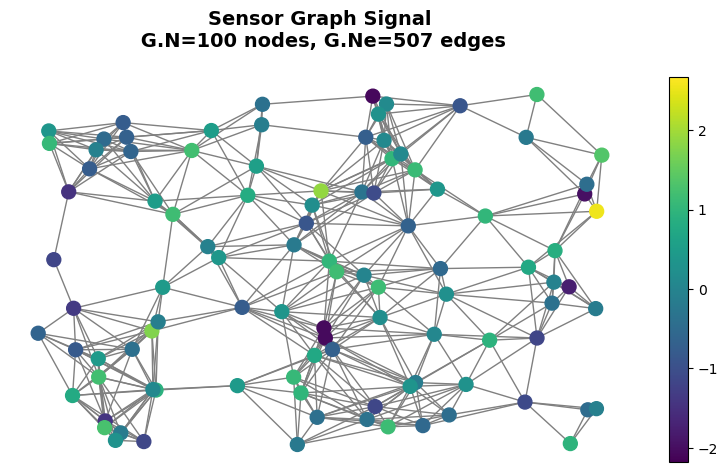

In [6]:
G = pygsp.graphs.Sensor(N=100)
signal = np.random.normal(size=G.N)

myGraphPlotSignal(G, 
            s = signal,
            title = "Sensor Graph Signal")

### 3.2. Graph Gradient and Divergence

**Graph Gradient:**

Given a graph $\mathcal{G} = \{ \mathcal{V}, \mathcal{E}, W \}$ and a graph signal $f : \mathcal{V} \rightarrow \mathbb{R}$, then the graph gradient is defined as:

$$
(\nabla f)_{ij} = \sqrt{w_{ij}} (f_i - f_j)
$$

This operation can be represented by: 

$$
F = D f
$$

where $f \in \mathbb{R}^N$, $F \in \mathbb{R}^{Ne}$ and $D \in \mathbb{R}^{Ne \times N}$.

In [30]:
G = pygsp.graphs.Sensor(N=100)
s = np.random.normal(size=G.N)

G.compute_differential_operator()
grad_s = G.D.dot(s)
assert grad_s.size == G.Ne

**Graph Divergence:**
Given a graph $\mathcal{G} = \{ \mathcal{V}, \mathcal{E}, W \}$ and a graph edge vector $F : \mathcal{E} \rightarrow \mathbb{R}$, then the graph divergence is defined as:

$$
(\text{div} F)_i = \sum_{j \in \mathcal{V}} \sqrt{w_{ij}} F_{ij}
$$

* Divergence is the adjoint operation of gradient:

$$
\text{div} = \nabla^*
$$

Therefore, in matrix representation,

$$
\text{Div} = D^T
$$

In [31]:
div_S = G.D.T.dot(grad_s)
assert div_S.size == G.N

### 3.3. Graph Laplacian

Graph Laplacian operator, $Ł : \mathbb{R}^N \rightarrow \mathbb{R}^N$, is graph divergence of graph gradient.

$$
(Ł f)_i = (\text{div} (\nabla f))_i = \sum_{j \in \mathcal{V}} w_{ij} (f_i - f_j)
$$

This is called **combinatorial Laplacian**. It can be represented by the following matrix:

$$
Ł = D - W
$$

where $D$ is degree matrix, which is a diagonal matrix whose $i^{th}$ diagonal element is $d_i = \sum_{j=1}^{N} w_{ij}$.

Normalized graph Laplacian is defined as:

$$
L = D^{-1/2}ŁD^{-1/2} = I - D^{-1/2}WD^{-1/2}
$$

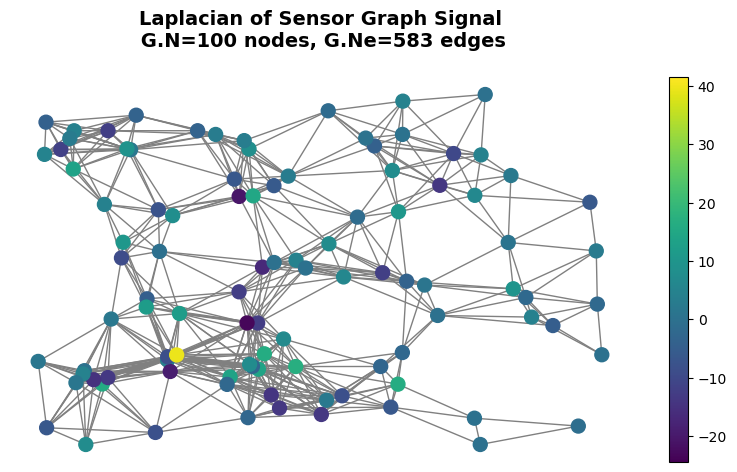

In [43]:
G.compute_laplacian()
lap_s = G.D.T.dot(G.D.dot(s))

np.testing.assert_allclose(lap_s, G.L.dot(s))

myGraphPlotSignal(G, 
            s = lap_s,
            title = "Laplacian of Sensor Graph Signal")

### 3.4. Graph Signal Smoothness

* **Local variation** of $f$ at vertex $i$:

$$
|| \nabla_i f ||_2 = \begin{bmatrix}
\sum_{e \in \mathcal{E} \text{ s.t. $e=(i,j)$ for some $j \in \mathcal{V}$}} (\left. \frac{\partial f}{\partial e} \right\vert_i)^2
\end{bmatrix}^{\frac{1}{2}}
$$

$$
|| \nabla_i f ||_2 = \begin{bmatrix}
\sum_{j \in \mathcal{N}_i} W_{i,j} [f(j) - f(i)]^2
\end{bmatrix}^{\frac{1}{2}}
$$

* Discrete p-Dirichlet form of $f$:

$$
S_p(f) = \frac{1}{p} \sum_{i \in \mathcal{V}} || \nabla_i f ||^p_2 = \frac{1}{p} \sum_{i \in \mathcal{V}} [\sum_{j \in \mathcal{N}_i} W_{i,j} [f(j)-f(i)]^2]^{\frac{p}{2}}
$$
This is for **global smoothness**.

   * $p=1$: total variation of the signal wrt graph
   * $p=2$:
   
$$
S_2(f) = \sum_{(i,j) \in \mathcal{E}} W_{i,j} [f(j) - f(i)]^2 = \textbf{f}^T Ł \textbf{f}
$$

**Note:** We can also define semi norm:
$$
||\textbf{f}||_Ł = ||Ł^{\frac{1}{2}} \textbf{f}||_2 = \sqrt{\textbf{f}^T Ł \textbf{f}} = \sqrt{S_2(f)}
$$

So, 

* $S_2(f)=0$ iff $f$ is constant across all vertices.

* $S_2(f)$ is small when the signal $f$ has similar values at neighboring vertices connected by an edge with a large weight, i.e. when it's smooth.

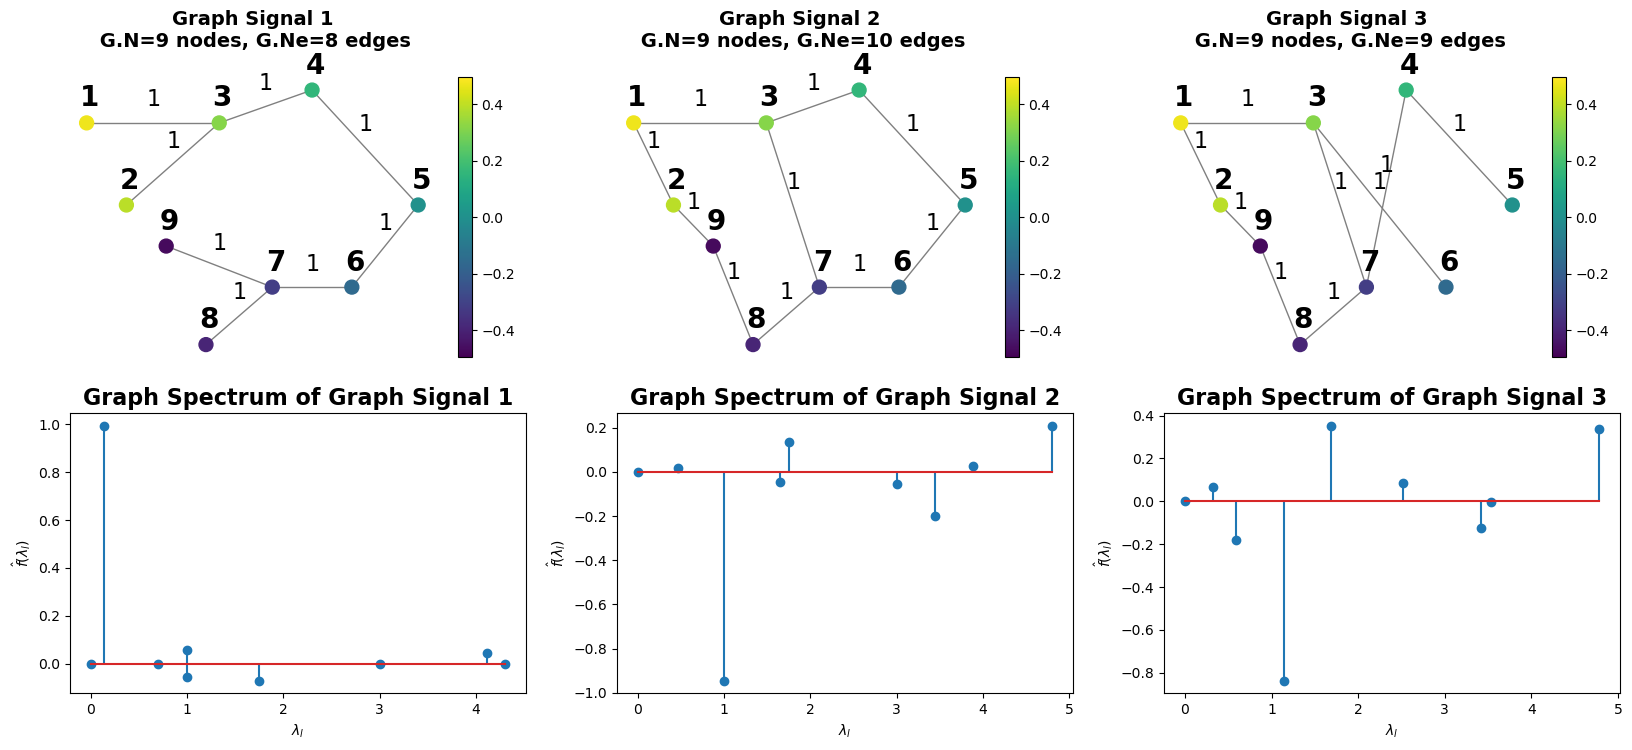

f^T L_1 f =  0.16049382716049385
f^T L_2 f =  1.2839506172839505
f^T L_3 f =  1.6543209876543208

=> Even thouugh we have the same signal values and same vertices, the difference on edges can affect the smoothness
	Here, G1 is the smoothest signal


In [51]:
coords = [
    [0,5],
    [0.6,4],
    [2,5],
    [3.4,5.4],
    [5,4],
    [4,3],
    [2.8,3],
    [1.8,2.3],
    [1.2,3.5]
]
s = np.array([6,5,4,2,0,-2,-4,-5,-6])
s = s / np.sum(s**2)**(0.5)

W1 = np.array([
    [0,0,1,0,0,0,0,0,0],
    [0,0,1,0,0,0,0,0,0],
    [1,1,0,1,0,0,0,0,0],
    [0,0,1,0,1,0,0,0,0],
    [0,0,0,1,0,1,0,0,0],
    [0,0,0,0,1,0,1,0,0],
    [0,0,0,0,0,1,0,1,1],
    [0,0,0,0,0,0,1,0,0],
    [0,0,0,0,0,0,1,0,0]
])
W2 = np.array([
    [0,1,1,0,0,0,0,0,0],
    [1,0,0,0,0,0,0,0,1],
    [1,0,0,1,0,0,1,0,0],
    [0,0,1,0,1,0,0,0,0],
    [0,0,0,1,0,1,0,0,0],
    [0,0,0,0,1,0,1,0,0],
    [0,0,1,0,0,1,0,1,0],
    [0,0,0,0,0,0,1,0,1],
    [0,1,0,0,0,0,0,1,0]
])
W3 = np.array([
    [0,1,1,0,0,0,0,0,0],
    [1,0,0,0,0,0,0,0,1],
    [1,0,0,0,0,1,1,0,0],
    [0,0,0,0,1,0,1,0,0],
    [0,0,0,1,0,0,0,0,0],
    [0,0,1,0,0,0,0,0,0],
    [0,0,1,1,0,0,0,1,0],
    [0,0,0,0,0,0,1,0,1],
    [0,1,0,0,0,0,0,1,0]
])


GS = [pygsp.graphs.Graph(W1), pygsp.graphs.Graph(W2), pygsp.graphs.Graph(W3)]
fig, axes = plt.subplots(2,3, figsize=(20,8))
s2s = []
for i in range(3):
    G = GS[i]
    G.compute_laplacian()
    G.compute_fourier_basis()
    myGraphPlotSignal(G,
                s=s,
                coords = coords,
                title = "Graph Signal " + str(i+1),
                display_vertexnames = True,
                display_edgeweights = True,
                ax=axes[0,i])
    
    s_hat = G.gft(s)
    axes[1,i].stem(G.e, s_hat)
    axes[1,i].set_xlabel("$\lambda_l$")
    axes[1,i].set_ylabel("$\hat{f}(\lambda_l)$")
    axes[1,i].set_title("Graph Spectrum of Graph Signal " + str(i+1), fontsize=16, fontweight=600)
    
    L = G.L.toarray()
    s2 = s.transpose() @ (L @ s)
    s2s.append(s2)
    
plt.show()

for i in range(3):
    print("f^T L_" + str(i+1) + " f = ", s2s[i], end="\n")
    
print("\n=> Even thouugh we have the same signal values and same vertices, the difference on edges can affect the smoothness")
print("\tHere, G1 is the smoothest signal")

### 3.4. Graph Fourier Transform 

For the undirected graphs, the graph Laplacian matrix, $Ł$, is real symmetric matrix. Therefore, it's positive semi definite matrix. It has a complete set of orthonormal eigenvectors: $\{u_l\}_{l=0,1,...,N-1}$

$$
Łu_l = \lambda_l u_l
$$
Also, the corresponding set of eigenvalues is $\{\lambda_l\}_{l=0,1,...,N-1}$. Without loss of generality, eigenvalues are ordered as $0=\lambda_0 < \lambda_1 < ... < \lambda_{N-1}=\lambda_{max}$. Then, the eigen-decomposition can be done as follows:

$$
Ł = U \Lambda U^T
$$
where $\Lambda = \text{diag}(\lambda_0,...,\lambda_{N-1})$.




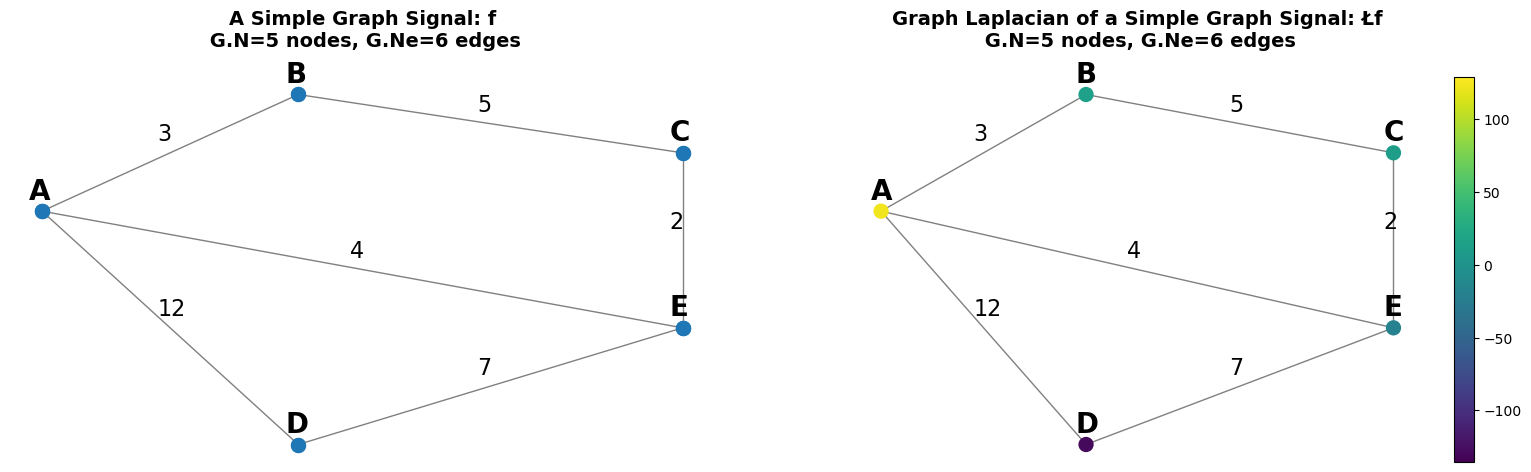

Set of ordered eigenvectors gives Fourier basis:  True 

First eigenvector corresponding: v_0 =  [0.4472136 0.4472136 0.4472136 0.4472136 0.4472136] , where 1/sqrt(5) = 0.4472135954999579 
	It also corresponds to eigenvalue lambda_0= -3.786762213785443e-15 

Proof of Orthonormality of Fourier basis:
	<u_0,u_0> = 1	
	<u_1,u_0> = 0	<u_1,u_1> = 1	
	<u_2,u_0> = 0	<u_2,u_1> = 0	<u_2,u_2> = 1	
	<u_3,u_0> = 0	<u_3,u_1> = 0	<u_3,u_2> = 0	<u_3,u_3> = 1	
	<u_4,u_0> = 0	<u_4,u_1> = 0	<u_4,u_2> = 0	<u_4,u_3> = 0	<u_4,u_4> = 1	


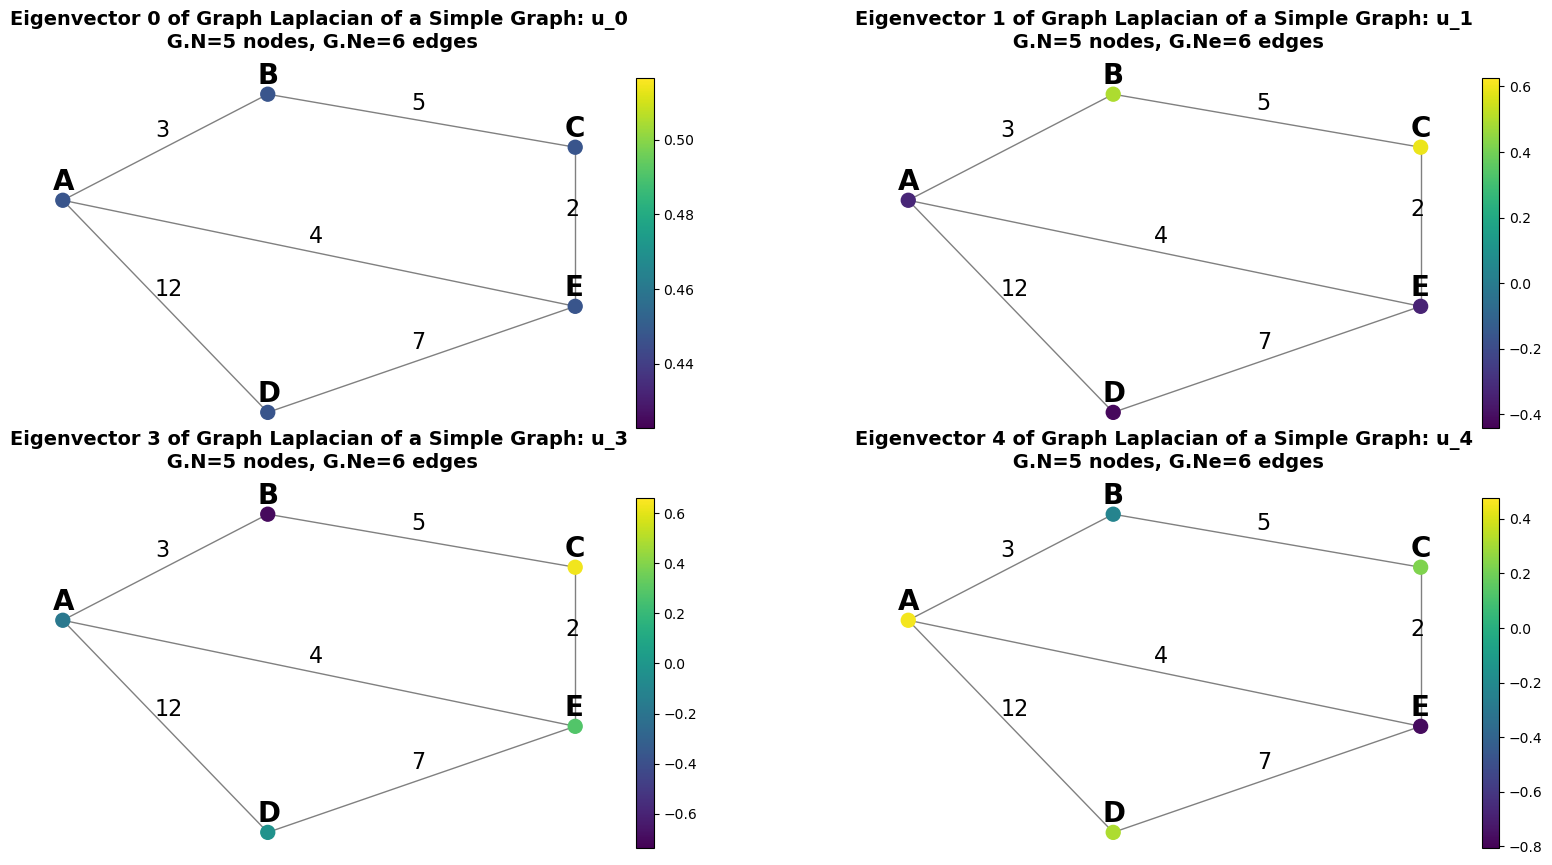

In [83]:
W = np.array([
    [0,3,0,12,4],
    [3,0,5,0,0],
    [0,5,0,0,2],
    [12,0,0,0,7],
    [4,0,2,7,0]
])
G = pygsp.graphs.Graph(W)

G.compute_laplacian()
G.compute_fourier_basis()

s = np.array([10,13,12,1,4])

L_s = G.L.dot(s)

fig, axes = plt.subplots(1,2, figsize=(20,5))

myGraphPlot(G,  
            coords = [[0,5], [2,7], [5,6], [2,1], [5,3]],
            vertex_names=["A", "B", "C", "D", "E"],
            title = "A Simple Graph Signal: f",
            display_vertexnames = True,
            display_edgeweights = True,
            ax=axes[0])

myGraphPlotSignal(G, 
            s = L_s,
            coords = [[0,5], [2,7], [5,6], [2,1], [5,3]],
            vertex_names=["A", "B", "C", "D", "E"],
            title = "Graph Laplacian of a Simple Graph Signal: Łf",
            display_vertexnames = True,
            display_edgeweights = True,
            ax=axes[1])
plt.show()

Lamb, U = np.linalg.eigh(G.L.toarray())

print("Set of ordered eigenvectors gives Fourier basis: ", (np.abs(U-G.U)<1e-15).all(), "\n")
print("First eigenvector corresponding: v_0 = ", U[:,0], ", where 1/sqrt(5) =", 1/np.sqrt(5), "\n\tIt also corresponds to eigenvalue lambda_0=", Lamb[0], "\n")

print("Proof of Orthonormality of Fourier basis:")
for i in range(5):
    print("\t", end="")
    for j in range(i+1):
        res = np.inner(U[:,i], U[:,j])
        if np.abs(res)< 1e-15:
            res = 0
        elif np.abs(res-1)<1e-15:
            res = 1
        print("<u_" + str(i) + ",u_" + str(j) + "> =", res, end="\t")
    print()
    
show_inds = [0,1,3,4]
fig, axes = plt.subplots(2,2, figsize=(20,10))
for i in range(2):
    for j in range(2):
        myGraphPlotSignal(G, 
                    s = G.U[:,i*2+j],
                    coords = [[0,5], [2,7], [5,6], [2,1], [5,3]],
                    vertex_names=["A", "B", "C", "D", "E"],
                    title = "Eigenvector " + str(show_inds[i*2+j]) + " of Graph Laplacian of a Simple Graph: u_" + str(show_inds[i*2+j]),
                    display_vertexnames = True,
                    display_edgeweights = True,
                    ax=axes[i,j])
plt.show()

**Note:** Graph Laplacian eigenvalues provide a notion of frequency. Eigenvectors associated to higher eigenvalues oscillate more rapidly.

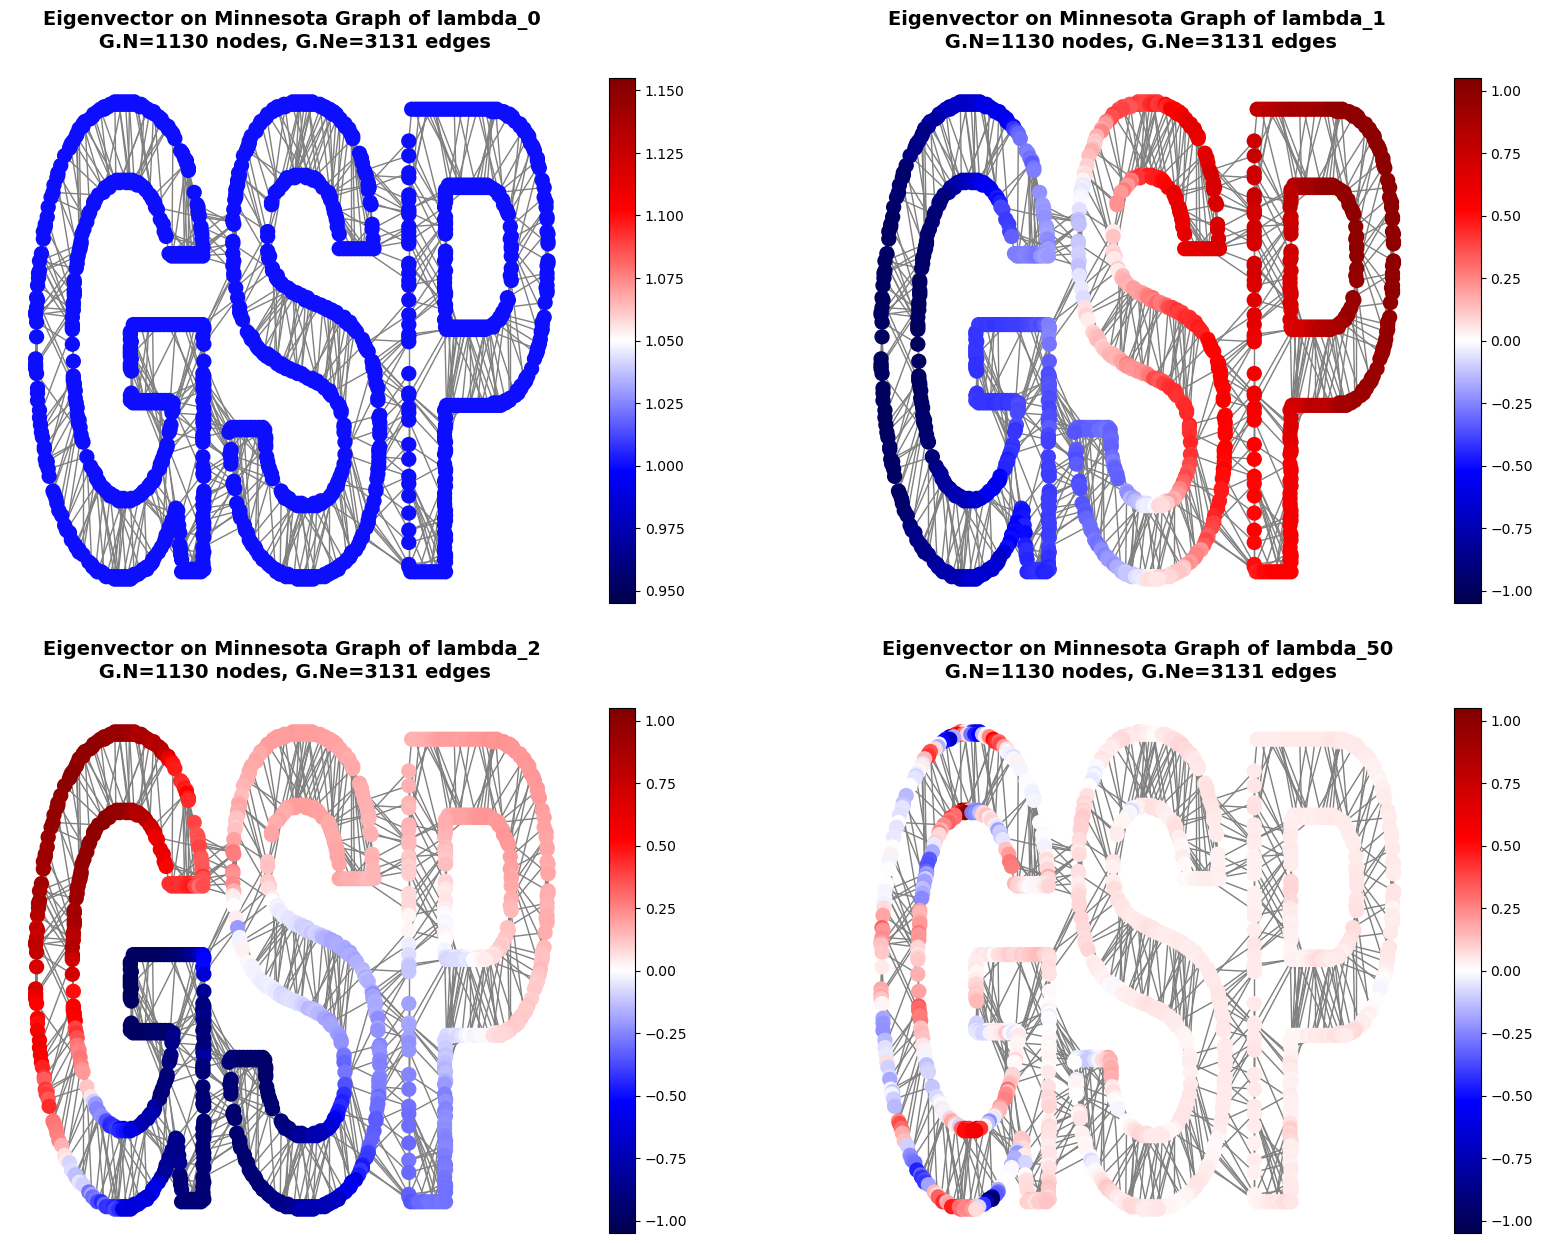

In [87]:
plt.rcParams['image.cmap'] = "seismic"
G = pygsp.graphs.Logo()
G.compute_laplacian()
G.compute_fourier_basis()

inds = [0, 1, 2, 50]

fig, axes = plt.subplots(2,2, figsize=(20,15))

for i, ind in enumerate(inds):
    a = np.min(G.U[:,ind])
    b = np.max(G.U[:,ind])
    
    if ((b-a)<1e-7):
        s = np.ones_like(G.U[:,ind])
    else:
        s = (G.U[:,ind] - a)/((b - a)/2) - 1
    
    myGraphPlotSignal(G, s = s, title="Eigenvector on Minnesota Graph of lambda_" + str(ind), ax=axes[i//2,i%2])
    
plt.show()
plt.rcParams['image.cmap'] = "turbo"

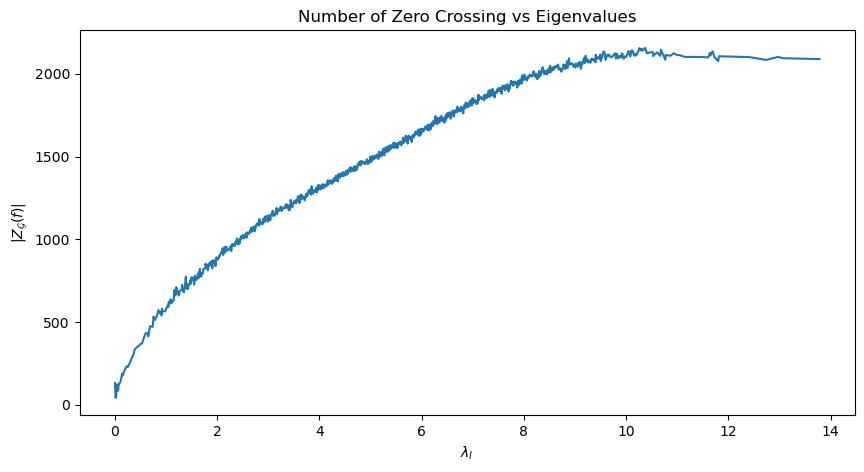

=> As eigenvalues increase, the number of zero crossing increases, i.e. the eigenvectors oscillate more rapidly.


In [90]:
G = pygsp.graphs.Logo()

G.compute_laplacian()
G.compute_fourier_basis()

U = G.U - np.mean(G.U, axis=0)

W = G.W.toarray()
inds = np.where(W!=0)
inds = list(zip(inds[0], inds[1]))
for cord in inds:
    try:
        inds.remove((cord[1], cord[0]))
    except:
        pass

def zero_crossings(s, inds):
    res = 0
    for cord in inds:
        if (s[cord[0]]*s[cord[1]] < 0):
            res += 1
    return res

zc_s = []
for i in range(G.N):
    zc_s.append(zero_crossings(U[:,i], inds))

fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(G.e, zc_s)
ax.set_ylabel("$|Z_{\mathcal{G}}(f)|$")
ax.set_xlabel("$\lambda_l$")
ax.set_title("Number of Zero Crossing vs Eigenvalues")
plt.show()

print("=> As eigenvalues increase, the number of zero crossing increases, i.e. the eigenvectors oscillate more rapidly.")

**Graph Fourier transform** is defined as:

$$
\hat{f}(\lambda_l) = < f, u_l > = \sum_{i \in \mathcal{V}} f(i) u^*_l(i)
$$

**Inverse graph Fourier transform** is defined as:
$$
f(i) = \sum_{l=0}^{N-1} \hat{f}(\lambda_l) u_{l}(i)
$$

These two transforms can be represented by matrices $U^T$ and $U$, respectively, where the columns of $U$ are eigenvectors of graph Laplacian operators, $\{u_l(i)\}_{i\in \mathcal{V}}$.


**An Example - Heat Kernel:**

The signals that can be represented in vertex ($s$) and graph spectral domain ($\hat{s}$) are called **kernels**.

Heat kernel is defined as:

$$ \hat{s}(\lambda_l) = e^{-\lambda_l} $$

Then, inverse Fourier transform can be applied to obtain the graph signal in vertex domain, $s(i)$:

$$ s(i) = \sum_{\lambda = 0}^{N-1} \hat{s}(\lambda_l) u_l(i) $$

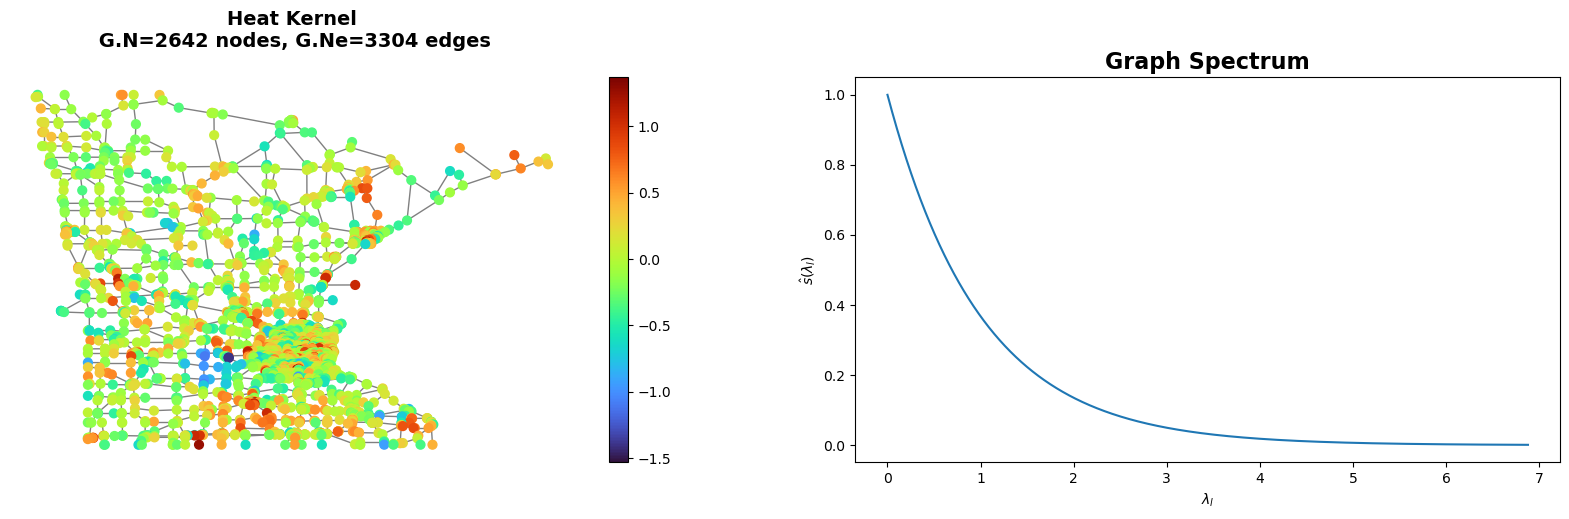

In [94]:
G = pygsp.graphs.Minnesota()
G.compute_laplacian()
G.compute_fourier_basis()

s_hat = np.exp(-G.e)

s = G.igft(s_hat)

fig, axes = plt.subplots(1,2,figsize=(20,5))
myGraphPlotSignal(G, 
            s = s,
            title = "Heat Kernel",
            ax=axes[0])
axes[1].plot(G.e, s_hat)
axes[1].set_title("Graph Spectrum", fontsize=16, fontweight=600)
axes[1].set_xlabel("$\lambda_l$")
axes[1].set_ylabel("$\hat{s}(\lambda_l)$")
plt.show()

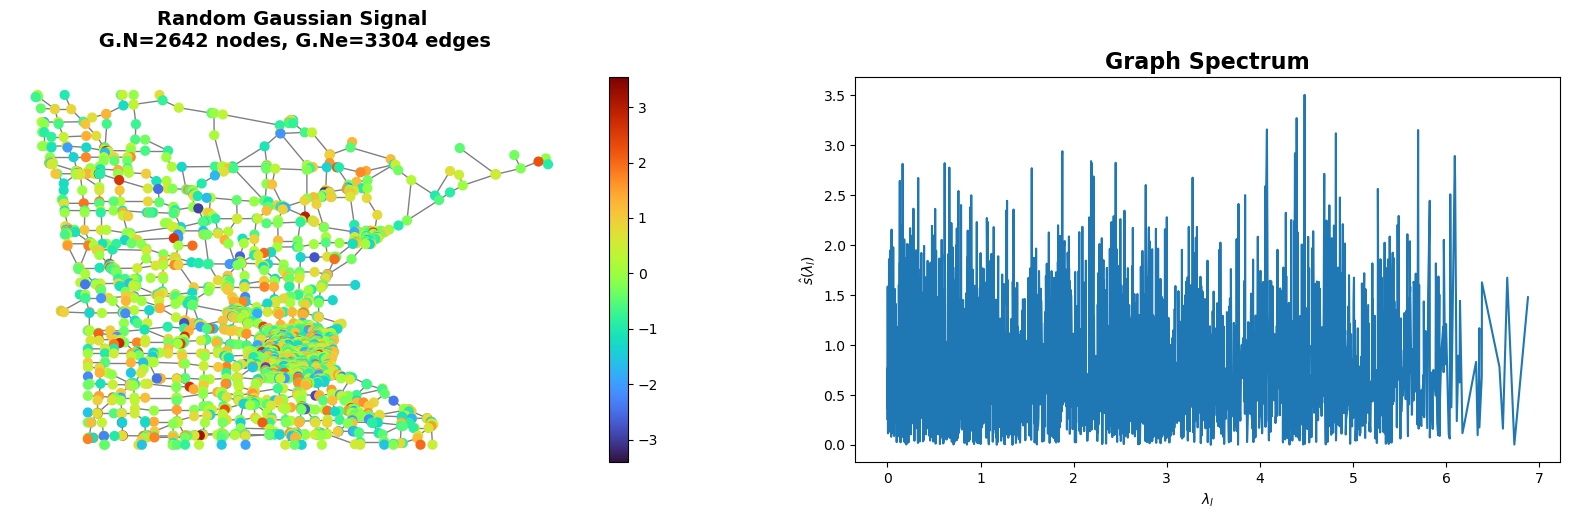

In [100]:
G = pygsp.graphs.Minnesota()
G.compute_laplacian()
G.compute_fourier_basis()

s = np.random.randn(G.N)

fig, axes = plt.subplots(1,2,figsize=(20,5))
myGraphPlotSignal(G, 
            s = s,
            title = "Random Gaussian Signal",
            ax=axes[0])

axes[1].plot(G.e, np.abs(G.gft(s)))
axes[1].set_title("Graph Spectrum", fontsize=16, fontweight=600)
axes[1].set_xlabel("$\lambda_l$")
axes[1].set_ylabel("$\hat{s}(\lambda_l)$")
plt.show()